### Imports

In [1]:
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, gc
import cv2
import time
import albumentations as albu
import random 
import pathlib
import torch.nn as nn
import timm
import torch.optim as optim
import torch.nn.functional as F
import wandb

from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

/home/jean/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jean/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

### Load and train data

In [2]:
df = pd.read_csv('../data/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


### Create Non-Overlapping Eeg Id Train Data

The competition data description says that test data does not have multiple crops from the same eeg_id. Therefore we will train and validate using only 1 crop per eeg_id.

In [3]:
# Associate spectrogram id with eeg id and add minimum coresponding offset
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

# Add maximum corresponding offset
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

# Associate eeg id to patient id
tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

# Add votes to corresponding eeg id
tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

# Transform number of votes to probs
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

# Convert probs into the target diagnosis
tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

# Add index to have the training csv
train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )

train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


### Read the training spectrograms from Kaggle

~ 10 mins from kaggle dataset

~ 1 min from custom dataset

In [4]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '../data/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('../data/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 96.9 ms, sys: 3.13 s, total: 3.23 s
Wall time: 3.72 s


### Read EEG Spectrograms

Using computed spectrograms from eegs

In [5]:
%%time
READ_EEG_SPEC_FILES = True

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'../data/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('../data/brain-spectrograms/eeg_specs.npy',allow_pickle=True).item()

0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 , 13500 , 13600 , 13700 , 13800 , 

### Train DataLoader

Dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size 128x256x8.

In [6]:
### Data aug

def time_warp(spectrogram, scale=0.7,p = 1.0):     
    if random.random() > p:
        return spectrogram
    scale_time = np.random.uniform(scale, 1/scale)
    warp_mat = np.array(([scale_time,0,0],[0,1,0]))
    warped_spectrogram = cv2.warpAffine(spectrogram, warp_mat, (spectrogram.shape[1], spectrogram.shape[0]),borderMode=cv2.BORDER_REFLECT)
    return warped_spectrogram

def frequency_shift(spectrogram, shift_max=0.1,p=1.0):
    if random.random() > p:
        return spectrogram
    shift = np.random.uniform(-shift_max, shift_max) * spectrogram.shape[0]
    return np.roll(spectrogram, int(shift), axis=0)

def rotate_spectrogram(spectrogram, angle_limit=2,p=1.0):
    augmenter = albu.Rotate(limit=angle_limit, p=p)
    return augmenter(image=spectrogram)['image']

def horizontal_flip(spectrogram, p=0.5):
    if random.random() > p:
        return spectrogram
    return albu.HorizontalFlip(p=p)(image = spectrogram)['image']

def scale_amplitude(spectrogram, scale_factor_range=(0.8, 1.2),p=1.0):
    if random.random() > p:
        return spectrogram
    scale_factor = np.random.uniform(*scale_factor_range)
    return spectrogram * scale_factor

def add_noise(spectrogram, noise_var=0.01,p=1.0):
    augmenter = albu.GaussNoise(var_limit=(0, noise_var), p=p)
    return augmenter(image=spectrogram)['image']

def random_crop(spectrogram, crop_height=120, crop_width=240, p=1.0):
    augmenter = albu.RandomCrop(height=crop_height, width=crop_width, p=p)
    return cv2.resize(augmenter(image=spectrogram)['image'],(256,128))

def mask_time_frequency(spectrogram, min_mask_size=0, max_mask_size=15, min_num_masks=0, max_num_masks=2, p=1.0):
    if random.random() > p:
        return spectrogram
    augmented = spectrogram.copy()
    num_time_masks = np.random.randint(min_num_masks, max_num_masks + 1)
    for _ in range(num_time_masks):
        mask_size_time = np.random.randint(min_mask_size, max_mask_size + 1)
        time_mask_start = np.random.randint(0, spectrogram.shape[1] - mask_size_time)
        augmented[:, time_mask_start:time_mask_start + mask_size_time] = 0
    num_freq_masks = np.random.randint(min_num_masks, max_num_masks + 1)
    for _ in range(num_freq_masks):
        mask_size_freq = np.random.randint(min_mask_size, max_mask_size + 1)
        freq_mask_start = np.random.randint(0, spectrogram.shape[0] - mask_size_freq)
        augmented[freq_mask_start:freq_mask_start + mask_size_freq, :] = 0
    return augmented

def mixup_spectrogram(spectrogram1, spectrogram2, alpha=1.0,p=1.0):
    if random.random() > p:
        return spectrogram
    lam = np.clip(np.random.beta(alpha, alpha), 0.4, 0.6)
    return mix_ratio * spectrogram1 + (1 - mix_ratio) * spectrogram2

def adjust_contrast(spectrogram, factor=1.5,p=1.0):
    augmenter = albu.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(factor - 1), p=p)
    return augmenter(image=spectrogram)['image']

def cutout(spectrogram,max_holes=5,max_height=32,max_width=32,fill_value=0,p=1):
    max_holes = np.random.randint(1,max_holes)
    max_height = np.random.randint(1,max_height)
    max_width = np.random.randint(1,max_width)
    return albu.CoarseDropout(max_holes=max_holes,max_height=max_height,max_width=max_width,fill_value=fill_value,p=p)(image = spectrogram)['image']


In [7]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(Dataset):

    def __init__(self, data, shuffle=False, augment=False, mode='train',
                 specs = spectrograms,eeg_specs = all_eegs): 

        self.data = data
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, index):
        'Generate one batch of data'
        X, y = self.__data_generation(index)
        if self.augment: X = self.__random_transform(X) 
            
        return X, y
                        
    def __data_generation(self, index):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((128,256,8),dtype='float32')
        y = np.zeros((6),dtype='float32')
        img = np.ones((128,256),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            r = 0
        else: 
            r = int( (row['min'] + row['max'])//4 )

        for k in range(4):
            # EXTRACT 300 ROWS OF SPECTROGRAM
            img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T

            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)

            # STANDARDIZE PER IMAGE
            ep = 1e-6
            m = np.nanmean(img.flatten())
            s = np.nanstd(img.flatten())
            img = (img-m)/(s+ep)
            img = np.nan_to_num(img, nan=0.0)

            # CROP TO 256 TIME STEPS
            X[14:-14,:,k] = img[:,22:-22] / 2.0
            
        # EEG SPECTROGRAMS
        img = self.eeg_specs[row.eeg_id]
        X[:,:,4:] = img

        if self.mode!='test':
            y = row[TARGETS]
            
        return X,np.array(y).astype(np.float32)
    
    def __random_transform(self, img):
        img = time_warp(img, p=0.2)
        img = frequency_shift(img, p=0.05)
#         img = rotate_spectrogram(img, p=0.01)
        img = horizontal_flip(img, p=0.5)
        img = scale_amplitude(img, p=0.1)
        img = add_noise(img, p=0.15)
        img = random_crop(img, p=0.05)
        img = adjust_contrast(img, p=0.1)
        img = mask_time_frequency(img, p=0.33)
        img = cutout(img, p=0.33)

        return img
    

            

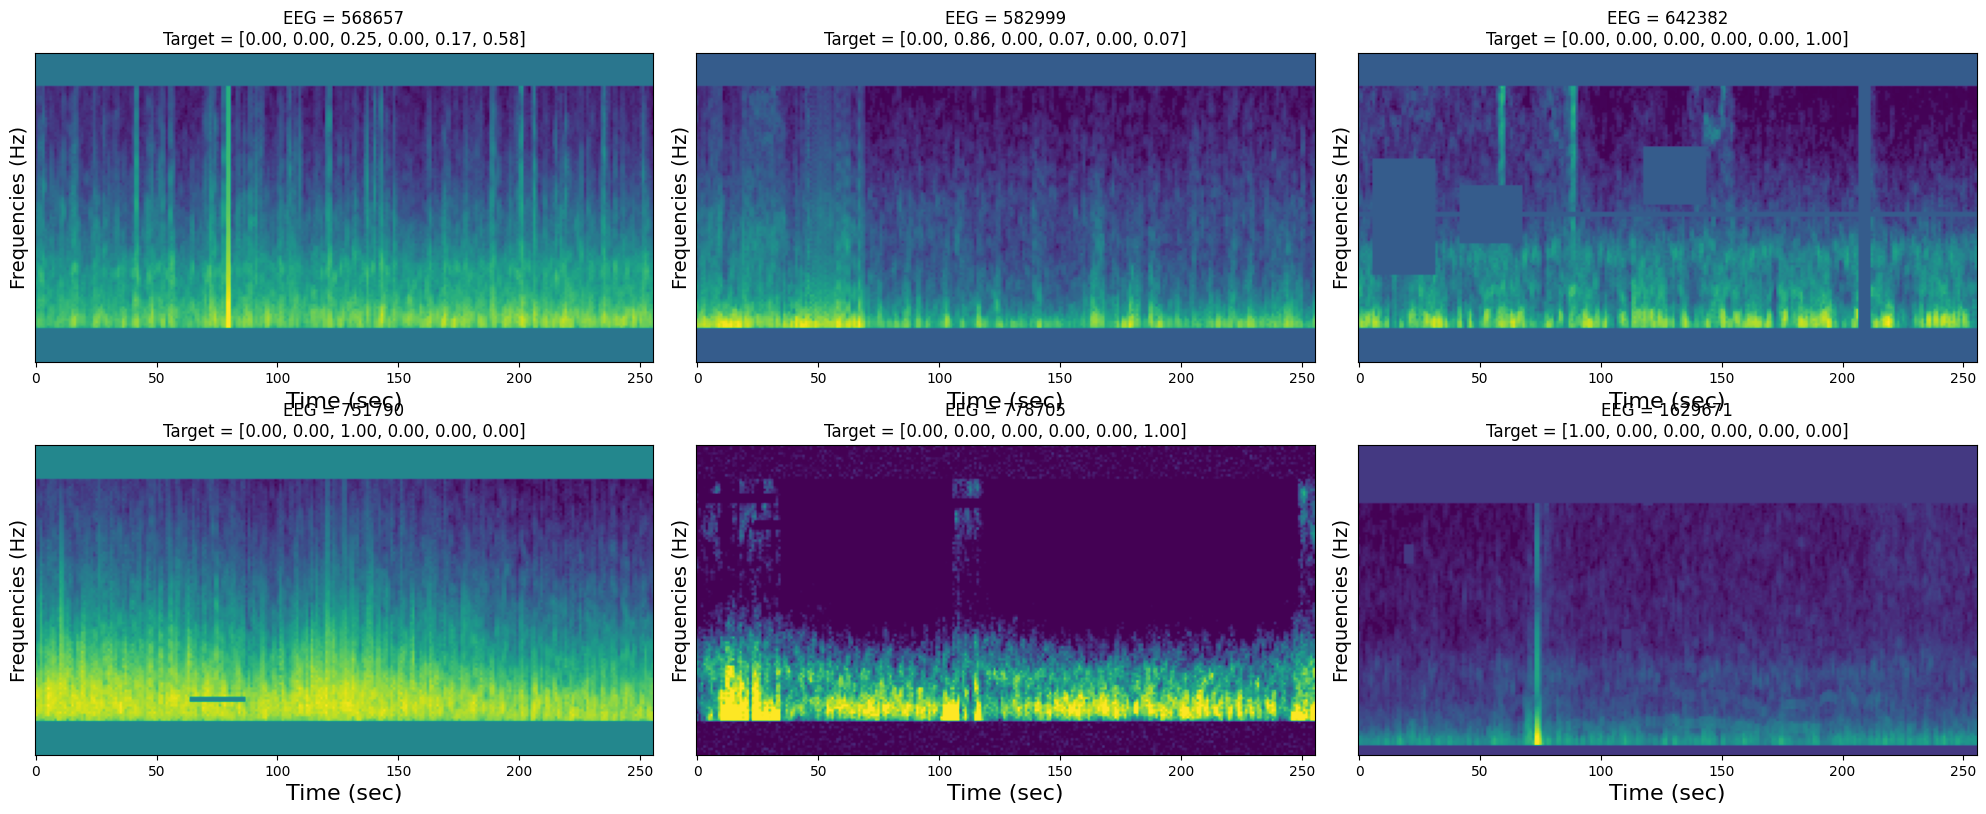

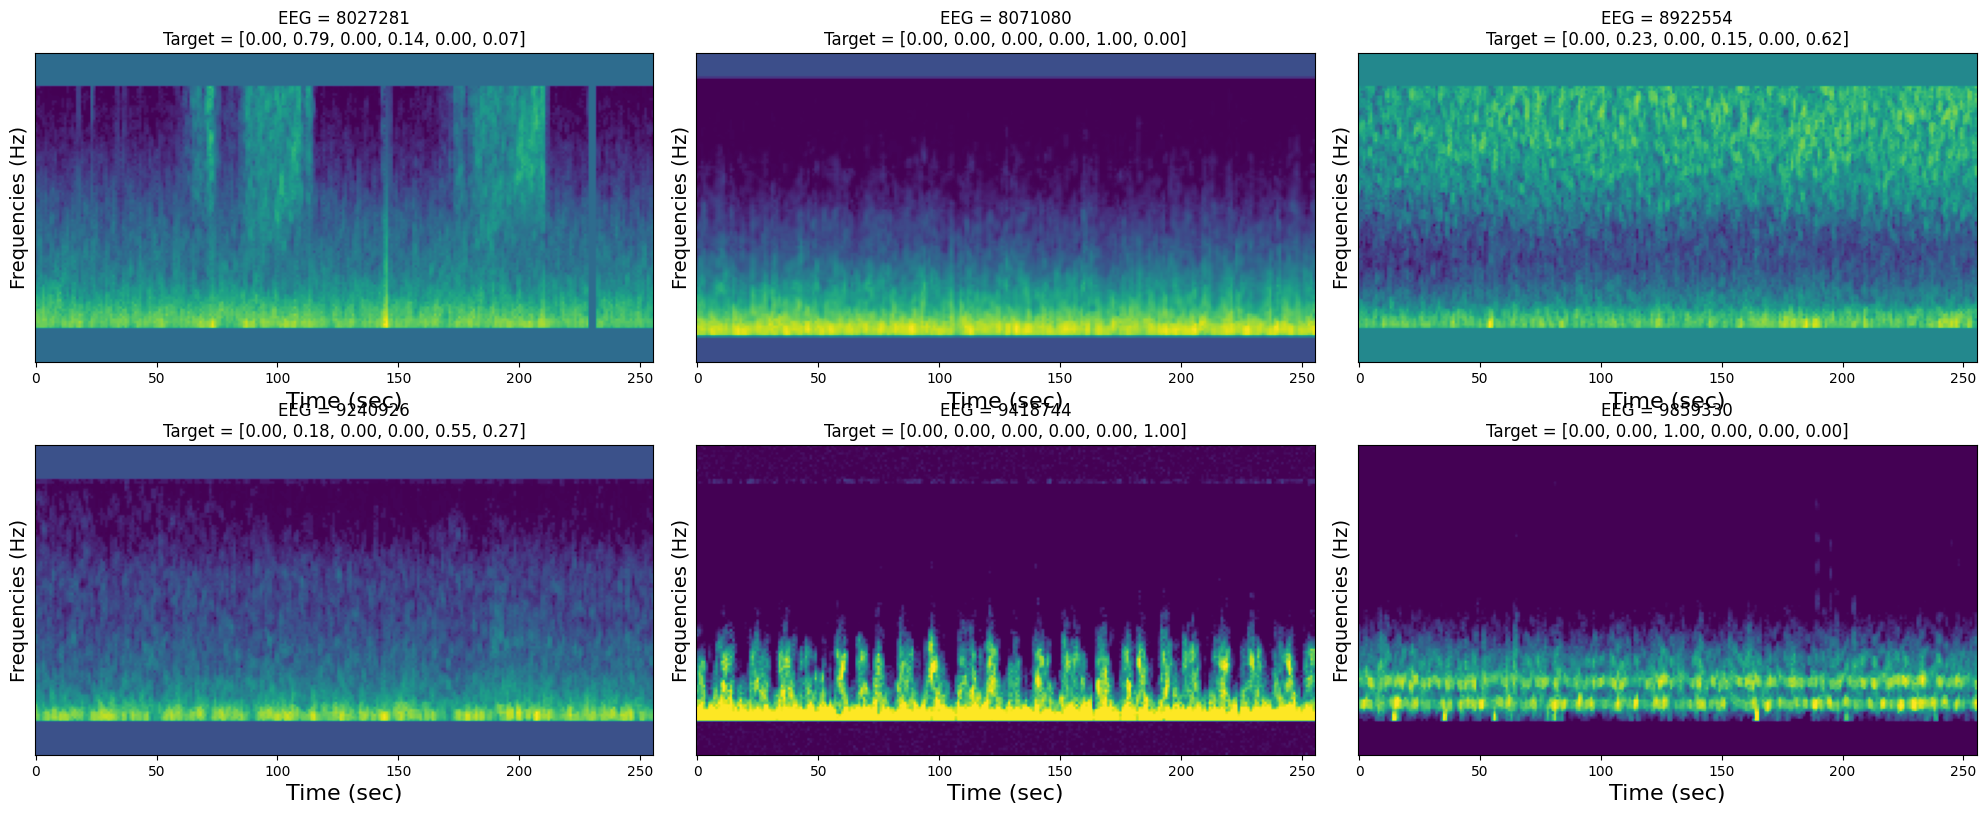

In [8]:
train_dataset = DataGenerator(train, augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Constants
ROWS = 2 # Define number of rows here
COLS = 3 # Define number of columns here
BATCHES = 2 # Define number of batches here

# Processing the dataloader
for i, (x, y) in enumerate(train_dataloader):
    if i >= BATCHES:
        break

    # Initialize figure and subplots
    fig, axes = plt.subplots(ROWS, COLS, figsize=(20, 8))
    axes = axes.flatten()  # Flatten for easy indexing

    for j in range(ROWS):
        for k in range(COLS):
            ax = axes[j * COLS + k]

            t = y[j * COLS + k]
            eeg = train.eeg_id.values[i * 32 + j * COLS + k]

            img = x[j * COLS + k, :, :, 0].flip(0)
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img - mn) / (mx - mn)

            ax.imshow(img)

            # Format the target string
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            tars += ']'

            ax.set_title(f'EEG = {eeg}\nTarget = {tars}', size=12)
            ax.set_yticks([])
            ax.set_ylabel('Frequencies (Hz)', size=14)
            ax.set_xlabel('Time (sec)', size=16)

    # Hide any unused subplots
    for ax in axes[len(x):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### Config for training

In [9]:
### Config

class config:
    model_name = "tf_efficientnet_b0_ns"
    n_fold = 5
    epochs = 2
    batch_size = 16  
    lr = 0.001
    print_freq = 20
    max_grad_norm = 1e7
    num_worker = 0
    output_dir = '../output'
    freeze = False
    gradient_accumulation_step = 1
    num_frozen_layers = 39
    weight_decay = 0.01



    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {device}")

DEVICE: cuda


In [10]:
wandb.finish()

In [11]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="HMS",
    
#     # track hyperparameters and run metadata
    config= {
        'model_name' : "tf_efficientnet_b0_ns",
        'n_fold' : 5,
        'epochs' : 25,
        'batch_size' : 16,
        'lr' : 1e-3,
        'print_freq' : 20,
        'max_grad_norm' : 1e7,
        'num_worker' : 8
    }
)

wandb: Currently logged in as: melkus37. Use `wandb login --relogin` to force relogin


### Validation

In [12]:
from sklearn.model_selection import KFold, GroupKFold


gkf = GroupKFold(n_splits=config.n_fold)
for fold, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
    train.loc[valid_index, "fold"] = int(fold)
    
display(train.groupby('fold').size())
display(train.head())

fold
0.0    3418
1.0    3418
2.0    3418
3.0    3418
4.0    3417
dtype: int64

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,2.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,2.0


### Model


In [13]:
model = timm.create_model(model_name=config.model_name, pretrained=True, num_classes=6, in_chans=8)
model.to(device)
num_parameter = sum(x.numel() for x in model.parameters())
print(f"Model has {num_parameter} parameters.")

/home/jean/miniconda3/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Model has 4016674 parameters.


In [14]:
y_out = model(x.to(device).permute(0,3,1,2))
y_out.shape

torch.Size([32, 6])

In [15]:
x.shape

torch.Size([32, 128, 256, 8])

### Scheduler


Maximum LR: 0.0009999994032517448 | Minimum LR: 4.0000000000000003e-07


/home/jean/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


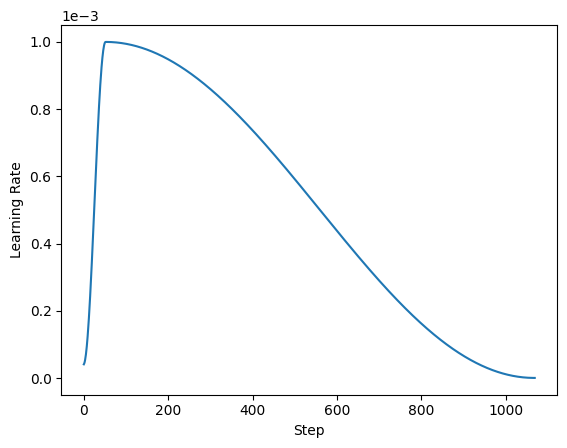

In [16]:
EPOCHS = config.epochs
BATCHES = len(train_dataloader)
steps = []
lrs = []
optim_lrs = []


optimizer = optim.AdamW(model.parameters(), lr=config.lr)

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.05,
    anneal_strategy="cos",
    final_div_factor=100,
)

for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)
        
max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()



### Loss function


In [17]:
# === Reduction = "mean" ===
criterion = nn.KLDivLoss(reduction="mean")
y_pred = F.log_softmax(y_out, dim=1)
y_true = F.softmax(y, dim=1).to(device)
output = criterion(y_pred, y_true)
print('MEAN')
print(f"Output: {output}")

print("\n", "="*100, "\n")

# === Reduction = "batchmean" ===
criterion = nn.KLDivLoss(reduction="batchmean")
y_pred = F.log_softmax(y_out, dim=1)
y_true = F.softmax(y, dim=1).to(device)
output = criterion(y_pred, y_true)
print('BATCHMEAN')
print(f"Output: {output}")

MEAN
Output: 0.24359509348869324


BATCHMEAN
Output: 1.4615705013275146


/home/jean/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


### Training

In [18]:
def mixup_aug(X,y, alpha = 1.0):
    
    alpha = 1.0
    lambda_val = torch.from_numpy(np.random.beta(alpha, alpha,(X.shape[0]))).double()

    perm = np.random.permutation(X.shape[0])

    lambda_val_target = lambda_val.reshape(X.shape[0],1)

    y = lambda_val_target * y + (1-lambda_val_target) * y[perm,:]

    lambda_val_data = lambda_val.reshape(X.shape[0],1,1,1)

    X = lambda_val_data * X + (1-lambda_val_data) * X[perm,:]
    
    return X.float(), y.float()

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
def train_epoch(train_loader, 
                    model, 
                    criterion,
                    optimizer,
                    epoch,
                    scheduler,
                    device):
    
    model.train()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        
        for step, (X, y) in enumerate(tqdm_train_loader):
            
            X,y = mixup_aug(X,y,config)
            
            X = X.permute(0,3,1,2).to(device)
            y = y.to(device)
            batch_size = y.size(0)
            
            optimizer.zero_grad()
            
            y_preds = model(X) 
            
            loss = criterion(F.log_softmax(y_preds, dim=1), y)
            
            losses.update(loss.item(), batch_size)
            loss.backward()
            
            optimizer.step()
            
            global_step += 1

            scheduler.step()
            
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

            end = time.time()
            
            if step % config.print_freq == 0 or step == (len(train_loader)-1):

                print('Epoch: [{0}][{1}/{2}] '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_last_lr()[0]))
                
    return losses.avg


In [21]:
def valid_epoch(valid_loader, 
                model, 
                criterion, 
                device):
    
    model.eval()
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    prediction_dict = {}
    preds = []
    start = end = time.time()

    
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, (X, y) in enumerate(tqdm_valid_loader):
                        
            X = X.to(device).permute(0,3,1,2)
            y = y.to(device)
            batch_size = y.size(0)

            with torch.no_grad():
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            
            losses.update(loss.item(), batch_size)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy())
            end = time.time()
            
            
            if step % config.print_freq == 0 or step == (len(valid_loader)-1):
                 print('EVAL: [{0}/{1}] '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses))
                    
    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

In [22]:
def compute_acc(valid_folds):
    correct = 0

    for index, row in valid_folds.iterrows():
        pred = row['target_preds'].argmax()
        true = np.array([row['seizure_vote'], 
                row['lpd_vote'], 
                row['gpd_vote'],
                row['lrda_vote'],
                row['grda_vote'], 
                row['other_vote']]).argmax()

        if pred == true:
            correct+=1
            
    return correct / len(valid_folds)

In [23]:
### Selected val fold
fold = 1

### Split
train_folds = train[train['fold'] != fold].reset_index(drop=True)
valid_folds = train[train['fold'] == fold].reset_index(drop=True)

### Datasets
train_dataset = DataGenerator(train_folds, config, mode="train", augment=True)
valid_dataset = DataGenerator(valid_folds, config, mode="train", augment=False)

### Dataloaders
train_loader = DataLoader(train_dataset,
                          batch_size=config.batch_size,
                          shuffle=True,
                          num_workers=config.num_worker, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset,
                          batch_size=config.batch_size,
                          shuffle=False,
                          num_workers=config.num_worker, pin_memory=True, drop_last=False)



### Optimizer
optimizer = torch.optim.AdamW(model.parameters())
### Scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=config.epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)

### Loss
criterion = nn.KLDivLoss(reduction="batchmean")

best_loss = np.inf

### Iterate through epochs
for epoch in range(config.epochs):
        start_time = time.time()

        ### Train
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        ### Evaluation
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        
        ### Scoring
        elapsed = time.time() - start_time
        
        print(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            
            print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        config.output_dir + f"/{config.model_name.replace('/', '_')}_fold_{fold}_best.pth")
            
            predictions = torch.load(config.output_dir + f"/{config.model_name.replace('/', '_')}_fold_{fold}_best.pth", 
                                 map_location=torch.device('cpu'))['predictions']

            valid_folds['target_preds'] = list(predictions)
            
        

        wandb.log({"train_loss":avg_train_loss, "val_loss": avg_val_loss, "acc": compute_acc(valid_folds)})
        
        torch.cuda.empty_cache()
        gc.collect()
        

        
wandb.finish()

Train:   0%|                           | 1/855 [00:00<08:28,  1.68train_batch/s]

Epoch: [1][0/855] Loss: 2.1020 Grad: 18.9811  LR: 0.00004008  


Train:   2%|▋                         | 21/855 [00:04<02:44,  5.07train_batch/s]

Epoch: [1][20/855] Loss: 2.1782 Grad: 21.4410  LR: 0.00007569  


Train:   5%|█▎                        | 42/855 [00:07<02:11,  6.20train_batch/s]

Epoch: [1][40/855] Loss: 1.8996 Grad: 21.2795  LR: 0.00017131  


Train:   7%|█▉                        | 62/855 [00:11<02:15,  5.86train_batch/s]

Epoch: [1][60/855] Loss: 1.7562 Grad: 18.9764  LR: 0.00031402  


Train:  10%|██▍                       | 82/855 [00:14<02:26,  5.28train_batch/s]

Epoch: [1][80/855] Loss: 1.6402 Grad: 13.8765  LR: 0.00048455  


Train:  12%|██▉                      | 102/855 [00:18<02:10,  5.76train_batch/s]

Epoch: [1][100/855] Loss: 1.5604 Grad: 12.2783  LR: 0.00065987  


Train:  14%|███▌                     | 122/855 [00:21<02:08,  5.71train_batch/s]

Epoch: [1][120/855] Loss: 1.5144 Grad: 11.6233  LR: 0.00081629  


Train:  16%|████                     | 141/855 [00:25<02:23,  4.98train_batch/s]

Epoch: [1][140/855] Loss: 1.4611 Grad: 8.6006  LR: 0.00093270  


Train:  19%|████▋                    | 162/855 [00:29<02:08,  5.38train_batch/s]

Epoch: [1][160/855] Loss: 1.4317 Grad: 7.9162  LR: 0.00099338  


Train:  21%|█████▎                   | 182/855 [00:32<01:57,  5.71train_batch/s]

Epoch: [1][180/855] Loss: 1.3909 Grad: 7.2992  LR: 0.00099987  


Train:  24%|█████▉                   | 202/855 [00:36<01:51,  5.87train_batch/s]

Epoch: [1][200/855] Loss: 1.3459 Grad: 5.5487  LR: 0.00099900  


Train:  26%|██████▍                  | 221/855 [00:40<02:06,  4.99train_batch/s]

Epoch: [1][220/855] Loss: 1.3103 Grad: 4.9861  LR: 0.00099729  


Train:  28%|███████                  | 242/855 [00:44<01:55,  5.31train_batch/s]

Epoch: [1][240/855] Loss: 1.2786 Grad: 4.8069  LR: 0.00099476  


Train:  31%|███████▋                 | 262/855 [00:47<01:36,  6.15train_batch/s]

Epoch: [1][260/855] Loss: 1.2465 Grad: 3.9332  LR: 0.00099140  


Train:  33%|████████▏                | 281/855 [00:51<02:07,  4.50train_batch/s]

Epoch: [1][280/855] Loss: 1.2226 Grad: 4.5117  LR: 0.00098722  


Train:  35%|████████▊                | 302/855 [00:55<01:39,  5.53train_batch/s]

Epoch: [1][300/855] Loss: 1.2025 Grad: 3.2215  LR: 0.00098224  


Train:  38%|█████████▍               | 322/855 [00:58<01:39,  5.37train_batch/s]

Epoch: [1][320/855] Loss: 1.1822 Grad: 2.4717  LR: 0.00097644  


Train:  40%|██████████               | 342/855 [01:02<01:39,  5.15train_batch/s]

Epoch: [1][340/855] Loss: 1.1603 Grad: 3.8188  LR: 0.00096986  


Train:  42%|██████████▌              | 362/855 [01:06<01:40,  4.91train_batch/s]

Epoch: [1][360/855] Loss: 1.1436 Grad: 3.3550  LR: 0.00096249  


Train:  45%|███████████▏             | 382/855 [01:10<01:33,  5.07train_batch/s]

Epoch: [1][380/855] Loss: 1.1250 Grad: 2.9309  LR: 0.00095435  


Train:  47%|███████████▋             | 401/855 [01:14<01:40,  4.52train_batch/s]

Epoch: [1][400/855] Loss: 1.1071 Grad: 3.0613  LR: 0.00094546  


Train:  49%|████████████▎            | 422/855 [01:18<01:20,  5.39train_batch/s]

Epoch: [1][420/855] Loss: 1.0910 Grad: 3.2718  LR: 0.00093582  


Train:  52%|████████████▉            | 442/855 [01:22<01:13,  5.59train_batch/s]

Epoch: [1][440/855] Loss: 1.0753 Grad: 3.1705  LR: 0.00092545  


Train:  54%|█████████████▍           | 461/855 [01:26<01:20,  4.89train_batch/s]

Epoch: [1][460/855] Loss: 1.0650 Grad: 3.7462  LR: 0.00091438  


Train:  56%|██████████████           | 482/855 [01:30<01:11,  5.21train_batch/s]

Epoch: [1][480/855] Loss: 1.0545 Grad: 2.2386  LR: 0.00090262  


Train:  59%|██████████████▋          | 502/855 [01:33<01:03,  5.59train_batch/s]

Epoch: [1][500/855] Loss: 1.0438 Grad: 2.6217  LR: 0.00089019  


Train:  61%|███████████████▎         | 522/855 [01:37<00:59,  5.60train_batch/s]

Epoch: [1][520/855] Loss: 1.0334 Grad: 2.9024  LR: 0.00087710  


Train:  63%|███████████████▊         | 541/855 [01:41<01:06,  4.70train_batch/s]

Epoch: [1][540/855] Loss: 1.0227 Grad: 2.1969  LR: 0.00086339  


Train:  66%|████████████████▍        | 561/855 [01:45<00:56,  5.21train_batch/s]

Epoch: [1][560/855] Loss: 1.0112 Grad: 1.7091  LR: 0.00084907  


Train:  68%|████████████████▉        | 581/855 [01:49<01:00,  4.55train_batch/s]

Epoch: [1][580/855] Loss: 1.0036 Grad: 2.8724  LR: 0.00083418  


Train:  70%|█████████████████▌       | 602/855 [01:54<00:51,  4.95train_batch/s]

Epoch: [1][600/855] Loss: 0.9943 Grad: 1.7874  LR: 0.00081872  


Train:  73%|██████████████████▏      | 622/855 [01:58<00:47,  4.94train_batch/s]

Epoch: [1][620/855] Loss: 0.9845 Grad: 2.7356  LR: 0.00080274  


Train:  75%|██████████████████▋      | 641/855 [02:01<00:42,  4.99train_batch/s]

Epoch: [1][640/855] Loss: 0.9751 Grad: 2.7956  LR: 0.00078625  


Train:  77%|███████████████████▎     | 661/855 [02:06<00:39,  4.93train_batch/s]

Epoch: [1][660/855] Loss: 0.9674 Grad: 1.9338  LR: 0.00076928  


Train:  80%|███████████████████▉     | 682/855 [02:10<00:35,  4.87train_batch/s]

Epoch: [1][680/855] Loss: 0.9609 Grad: 3.0323  LR: 0.00075187  


Train:  82%|████████████████████▌    | 702/855 [02:14<00:29,  5.18train_batch/s]

Epoch: [1][700/855] Loss: 0.9548 Grad: 1.9080  LR: 0.00073403  


Train:  84%|█████████████████████    | 722/855 [02:18<00:25,  5.13train_batch/s]

Epoch: [1][720/855] Loss: 0.9478 Grad: 2.3899  LR: 0.00071581  


Train:  87%|█████████████████████▋   | 742/855 [02:22<00:22,  5.07train_batch/s]

Epoch: [1][740/855] Loss: 0.9409 Grad: 1.6006  LR: 0.00069722  


Train:  89%|██████████████████████▎  | 762/855 [02:26<00:18,  5.04train_batch/s]

Epoch: [1][760/855] Loss: 0.9345 Grad: 1.9720  LR: 0.00067831  


Train:  91%|██████████████████████▊  | 782/855 [02:30<00:14,  5.11train_batch/s]

Epoch: [1][780/855] Loss: 0.9266 Grad: 1.8586  LR: 0.00065910  


Train:  94%|███████████████████████▍ | 801/855 [02:33<00:10,  4.99train_batch/s]

Epoch: [1][800/855] Loss: 0.9198 Grad: 2.0480  LR: 0.00063963  


Train:  96%|████████████████████████ | 822/855 [02:38<00:06,  4.93train_batch/s]

Epoch: [1][820/855] Loss: 0.9119 Grad: 1.5433  LR: 0.00061992  


Train:  98%|████████████████████████▌| 841/855 [02:42<00:03,  4.23train_batch/s]

Epoch: [1][840/855] Loss: 0.9066 Grad: 1.8531  LR: 0.00060002  


Train: 100%|█████████████████████████| 855/855 [02:45<00:00,  5.16train_batch/s]


Epoch: [1][854/855] Loss: 0.9034 Grad: 1.9502  LR: 0.00058598  


Validation:   1%|▏                     | 2/214 [00:00<00:16, 12.62valid_batch/s]

EVAL: [0/214] Loss: 0.9672 


Validation:  10%|██▏                  | 22/214 [00:01<00:14, 12.81valid_batch/s]

EVAL: [20/214] Loss: 0.9163 


Validation:  20%|████                 | 42/214 [00:03<00:14, 11.90valid_batch/s]

EVAL: [40/214] Loss: 0.9391 


Validation:  29%|██████               | 62/214 [00:05<00:12, 12.34valid_batch/s]

EVAL: [60/214] Loss: 0.9571 


Validation:  38%|████████             | 82/214 [00:06<00:09, 13.26valid_batch/s]

EVAL: [80/214] Loss: 0.9792 


Validation:  48%|█████████▌          | 102/214 [00:08<00:08, 13.29valid_batch/s]

EVAL: [100/214] Loss: 0.9758 


Validation:  57%|███████████▍        | 122/214 [00:09<00:06, 13.40valid_batch/s]

EVAL: [120/214] Loss: 0.9797 


Validation:  66%|█████████████▎      | 142/214 [00:11<00:05, 12.74valid_batch/s]

EVAL: [140/214] Loss: 0.9808 


Validation:  76%|███████████████▏    | 162/214 [00:12<00:04, 12.09valid_batch/s]

EVAL: [160/214] Loss: 0.9629 


Validation:  85%|█████████████████   | 182/214 [00:14<00:02, 12.75valid_batch/s]

EVAL: [180/214] Loss: 0.9632 


Validation:  94%|██████████████████▉ | 202/214 [00:16<00:00, 12.25valid_batch/s]

EVAL: [200/214] Loss: 0.9634 


Validation: 100%|████████████████████| 214/214 [00:17<00:00, 12.56valid_batch/s]


EVAL: [213/214] Loss: 0.9601 
Epoch 1 - avg_train_loss: 0.9034  avg_val_loss: 0.9601  time: 183s
Epoch 1 - Save Best Loss: 0.9601 Model


Train:   0%|                           | 1/855 [00:00<03:18,  4.30train_batch/s]

Epoch: [2][0/855] Loss: 0.7881 Grad: 2.0741  LR: 0.00058498  


Train:   2%|▋                         | 21/855 [00:04<03:07,  4.44train_batch/s]

Epoch: [2][20/855] Loss: 0.6480 Grad: 1.9317  LR: 0.00056480  


Train:   5%|█▎                        | 42/855 [00:08<02:41,  5.03train_batch/s]

Epoch: [2][40/855] Loss: 0.6670 Grad: 1.6079  LR: 0.00054452  


Train:   7%|█▊                        | 61/855 [00:12<02:41,  4.92train_batch/s]

Epoch: [2][60/855] Loss: 0.6779 Grad: 2.4455  LR: 0.00052417  


Train:   9%|██▍                       | 81/855 [00:16<02:39,  4.86train_batch/s]

Epoch: [2][80/855] Loss: 0.6602 Grad: 1.6802  LR: 0.00050377  


Train:  12%|██▉                      | 101/855 [00:21<02:53,  4.35train_batch/s]

Epoch: [2][100/855] Loss: 0.6598 Grad: 2.1842  LR: 0.00048337  


Train:  14%|███▌                     | 121/855 [00:25<02:46,  4.41train_batch/s]

Epoch: [2][120/855] Loss: 0.6562 Grad: 1.6962  LR: 0.00046300  


Train:  17%|████▏                    | 142/855 [00:30<02:25,  4.89train_batch/s]

Epoch: [2][140/855] Loss: 0.6676 Grad: 2.1494  LR: 0.00044268  


Train:  19%|████▋                    | 161/855 [00:34<02:17,  5.03train_batch/s]

Epoch: [2][160/855] Loss: 0.6694 Grad: 2.9489  LR: 0.00042247  


Train:  21%|█████▎                   | 181/855 [00:39<02:49,  3.98train_batch/s]

Epoch: [2][180/855] Loss: 0.6750 Grad: 3.6107  LR: 0.00040238  


Train:  24%|█████▉                   | 201/855 [00:43<02:38,  4.13train_batch/s]

Epoch: [2][200/855] Loss: 0.6662 Grad: 1.9390  LR: 0.00038246  


Train:  26%|██████▍                  | 221/855 [00:48<02:27,  4.29train_batch/s]

Epoch: [2][220/855] Loss: 0.6603 Grad: 1.5534  LR: 0.00036273  


Train:  28%|███████                  | 241/855 [00:52<02:22,  4.29train_batch/s]

Epoch: [2][240/855] Loss: 0.6613 Grad: 2.1653  LR: 0.00034323  


Train:  31%|███████▋                 | 261/855 [00:57<02:05,  4.75train_batch/s]

Epoch: [2][260/855] Loss: 0.6600 Grad: 2.6933  LR: 0.00032400  


Train:  33%|████████▏                | 281/855 [01:02<02:18,  4.14train_batch/s]

Epoch: [2][280/855] Loss: 0.6600 Grad: 1.8591  LR: 0.00030505  


Train:  35%|████████▊                | 301/855 [01:06<02:19,  3.96train_batch/s]

Epoch: [2][300/855] Loss: 0.6588 Grad: 2.0844  LR: 0.00028644  


Train:  38%|█████████▍               | 321/855 [01:11<02:15,  3.95train_batch/s]

Epoch: [2][320/855] Loss: 0.6585 Grad: 1.8395  LR: 0.00026817  


Train:  40%|█████████▉               | 341/855 [01:16<02:01,  4.22train_batch/s]

Epoch: [2][340/855] Loss: 0.6581 Grad: 1.9979  LR: 0.00025030  


Train:  42%|██████████▌              | 361/855 [01:21<01:50,  4.48train_batch/s]

Epoch: [2][360/855] Loss: 0.6596 Grad: 2.3994  LR: 0.00023284  


Train:  45%|███████████▏             | 381/855 [01:25<02:04,  3.80train_batch/s]

Epoch: [2][380/855] Loss: 0.6555 Grad: 2.1217  LR: 0.00021583  


Train:  47%|███████████▋             | 401/855 [01:30<01:46,  4.25train_batch/s]

Epoch: [2][400/855] Loss: 0.6528 Grad: 1.2125  LR: 0.00019929  


Train:  49%|████████████▎            | 421/855 [01:35<01:37,  4.45train_batch/s]

Epoch: [2][420/855] Loss: 0.6542 Grad: 3.1227  LR: 0.00018325  


Train:  52%|████████████▉            | 441/855 [01:39<01:46,  3.89train_batch/s]

Epoch: [2][440/855] Loss: 0.6514 Grad: 2.6744  LR: 0.00016774  


Train:  54%|█████████████▍           | 461/855 [01:44<01:30,  4.33train_batch/s]

Epoch: [2][460/855] Loss: 0.6495 Grad: 1.5053  LR: 0.00015279  


Train:  56%|██████████████           | 481/855 [01:49<01:33,  4.01train_batch/s]

Epoch: [2][480/855] Loss: 0.6464 Grad: 1.7955  LR: 0.00013841  


Train:  59%|██████████████▋          | 501/855 [01:53<01:19,  4.43train_batch/s]

Epoch: [2][500/855] Loss: 0.6450 Grad: 2.1631  LR: 0.00012464  


Train:  61%|███████████████▏         | 521/855 [01:58<01:13,  4.56train_batch/s]

Epoch: [2][520/855] Loss: 0.6419 Grad: 1.6737  LR: 0.00011149  


Train:  63%|███████████████▊         | 541/855 [02:03<01:11,  4.40train_batch/s]

Epoch: [2][540/855] Loss: 0.6409 Grad: 2.1163  LR: 0.00009899  


Train:  66%|████████████████▍        | 562/855 [02:07<01:04,  4.52train_batch/s]

Epoch: [2][560/855] Loss: 0.6382 Grad: 1.6326  LR: 0.00008716  


Train:  68%|████████████████▉        | 581/855 [02:12<01:04,  4.22train_batch/s]

Epoch: [2][580/855] Loss: 0.6365 Grad: 2.0488  LR: 0.00007602  


Train:  70%|█████████████████▌       | 601/855 [02:17<01:04,  3.91train_batch/s]

Epoch: [2][600/855] Loss: 0.6348 Grad: 2.4381  LR: 0.00006559  


Train:  73%|██████████████████▏      | 621/855 [02:22<00:55,  4.24train_batch/s]

Epoch: [2][620/855] Loss: 0.6331 Grad: 1.1275  LR: 0.00005588  


Train:  75%|██████████████████▋      | 641/855 [02:26<00:44,  4.84train_batch/s]

Epoch: [2][640/855] Loss: 0.6329 Grad: 2.6519  LR: 0.00004690  


Train:  77%|███████████████████▎     | 661/855 [02:30<00:42,  4.56train_batch/s]

Epoch: [2][660/855] Loss: 0.6321 Grad: 2.1179  LR: 0.00003869  


Train:  80%|███████████████████▉     | 681/855 [02:36<00:46,  3.73train_batch/s]

Epoch: [2][680/855] Loss: 0.6325 Grad: 1.2348  LR: 0.00003124  


Train:  82%|████████████████████▍    | 701/855 [02:40<00:39,  3.93train_batch/s]

Epoch: [2][700/855] Loss: 0.6314 Grad: 1.7346  LR: 0.00002458  


Train:  84%|█████████████████████    | 721/855 [02:45<00:32,  4.17train_batch/s]

Epoch: [2][720/855] Loss: 0.6310 Grad: 2.2550  LR: 0.00001871  


Train:  87%|█████████████████████▋   | 741/855 [02:50<00:26,  4.23train_batch/s]

Epoch: [2][740/855] Loss: 0.6316 Grad: 1.6920  LR: 0.00001364  


Train:  89%|██████████████████████▎  | 761/855 [02:55<00:22,  4.26train_batch/s]

Epoch: [2][760/855] Loss: 0.6308 Grad: 2.7833  LR: 0.00000938  


Train:  91%|██████████████████████▊  | 781/855 [03:00<00:17,  4.34train_batch/s]

Epoch: [2][780/855] Loss: 0.6283 Grad: 1.7086  LR: 0.00000594  


Train:  94%|███████████████████████▍ | 801/855 [03:05<00:13,  3.88train_batch/s]

Epoch: [2][800/855] Loss: 0.6280 Grad: 2.2819  LR: 0.00000332  


Train:  96%|████████████████████████ | 821/855 [03:09<00:07,  4.54train_batch/s]

Epoch: [2][820/855] Loss: 0.6281 Grad: 1.2428  LR: 0.00000153  


Train:  98%|████████████████████████▌| 841/855 [03:14<00:03,  4.37train_batch/s]

Epoch: [2][840/855] Loss: 0.6267 Grad: 1.8572  LR: 0.00000058  


Train: 100%|█████████████████████████| 855/855 [03:17<00:00,  4.33train_batch/s]


Epoch: [2][854/855] Loss: 0.6261 Grad: 3.5892  LR: 0.00000040  


Validation:   1%|▏                     | 2/214 [00:00<00:17, 11.85valid_batch/s]

EVAL: [0/214] Loss: 0.7318 


Validation:  10%|██▏                  | 22/214 [00:01<00:16, 11.90valid_batch/s]

EVAL: [20/214] Loss: 0.7300 


Validation:  20%|████                 | 42/214 [00:03<00:15, 11.46valid_batch/s]

EVAL: [40/214] Loss: 0.7398 


Validation:  29%|██████               | 62/214 [00:05<00:13, 11.08valid_batch/s]

EVAL: [60/214] Loss: 0.7555 


Validation:  38%|████████             | 82/214 [00:07<00:11, 11.48valid_batch/s]

EVAL: [80/214] Loss: 0.7703 


Validation:  48%|█████████▌          | 102/214 [00:08<00:10, 11.13valid_batch/s]

EVAL: [100/214] Loss: 0.7688 


Validation:  57%|███████████▍        | 122/214 [00:10<00:08, 10.85valid_batch/s]

EVAL: [120/214] Loss: 0.7767 


Validation:  66%|█████████████▎      | 142/214 [00:12<00:06, 11.70valid_batch/s]

EVAL: [140/214] Loss: 0.7815 


Validation:  76%|███████████████▏    | 162/214 [00:14<00:04, 12.02valid_batch/s]

EVAL: [160/214] Loss: 0.7673 


Validation:  85%|█████████████████   | 182/214 [00:15<00:02, 11.43valid_batch/s]

EVAL: [180/214] Loss: 0.7694 


Validation:  94%|██████████████████▉ | 202/214 [00:17<00:01, 10.82valid_batch/s]

EVAL: [200/214] Loss: 0.7714 


Validation: 100%|████████████████████| 214/214 [00:18<00:00, 11.33valid_batch/s]


EVAL: [213/214] Loss: 0.7655 
Epoch 2 - avg_train_loss: 0.6261  avg_val_loss: 0.7655  time: 216s
Epoch 2 - Save Best Loss: 0.7655 Model


acc,▁█
train_loss,█▁
val_loss,█▁
acc,0.61556
train_loss,0.62612
val_loss,0.76546


In [ ]:
### Train on all data
fold = -1

### Split
train_folds = train[train['fold'] != fold].reset_index(drop=True)
 
### Datasets
train_dataset = DataGenerator(train_folds, config, mode="train", augment=True)

### Dataloaders
train_loader = DataLoader(train_dataset,
                          batch_size=config.batch_size,
                          shuffle=True,
                          num_workers=config.num_worker, pin_memory=True, drop_last=False)


### Optimizer
optimizer = torch.optim.AdamW(model.parameters())
### Scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=config.epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos",
    final_div_factor=100,
)

### Loss
criterion = nn.KLDivLoss(reduction="batchmean")

### Iterate through epochs
for epoch in range(config.epochs):
        start_time = time.time()

        ### Train
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        
        ### Scoring
        elapsed = time.time() - start_time
        
        print(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}   time: {elapsed:.0f}s')
        
            

torch.save({'model': model.state_dict()},
            config.output_dir + f"/{config.model_name.replace('/', '_')}_fold_{fold}_best.pth")



wandb.log({"train_loss":avg_train_loss})

torch.cuda.empty_cache()
gc.collect()
        

        
wandb.finish()